# Classical Shadow Transformer

## Initialization

In [2]:
from CST import *
import matplotlib.pyplot as plt
import pickle
import torch
device = torch.device('cuda' if (torch.cuda.is_available()) else 'cpu') # 'cpu', 'cuda', 'mps' ..
print(device)


cuda


## Testing

### Transformer

#### Test 1: Log Probability Estimation

**Goal:** show that the log probability accumulated at sampling is the same as log probability evaluated by the model directly.

Create a model and put into evaluation mode (to disable dropout).

In [3]:
tf = Transformer(outtk_size=2)
tf.eval()
x = torch.tensor([[4],[4],[5],[5],[6],[6]])

In [4]:
y, logprob = tf.sample(x, 1, need_logprob=True)
y, logprob

(tensor([[2],
         [1],
         [1],
         [1],
         [2],
         [2]]),
 tensor([-1.0359, -0.4383, -0.5331, -0.5331, -0.8408, -0.8408]))

In [5]:
tf.logprob(x, y)

tensor([-1.0359, -0.4383, -0.5331, -0.5331, -0.8408, -0.8408],
       grad_fn=<SumBackward1>)

Results are matched up.

#### Test 2: Generative Modeling

**Goal:** test the ability of the transformer model to learn sequence-to-sequence map.

In [6]:
tf = Transformer(outtk_size=2)
x = torch.tensor([[4],[4],[5],[5],[6],[6],[6]])
y = torch.tensor([[1],[1],[1],[2],[1],[2],[2]])
y1 = torch.tensor([[1],[2],[1],[2],[1],[2],[2]])

In [7]:
optimizer = torch.optim.Adam(tf.parameters(), lr=0.001)

In [8]:
tf.train()
for epoch in range(10):
    optimizer.zero_grad()
    loss = -tf.logprob(x, y).mean()
    loss.backward()
    optimizer.step()
    print('{:3d}: {:8.5g}'.format(epoch, loss.item()))

  0:  0.82738
  1:  0.59744
  2:  0.61077
  3:  0.64973
  4:  0.59737
  5:  0.54241
  6:  0.50676
  7:  0.49967
  8:   0.5199
  9:  0.48541


Learns to predict $y$ from $x$.

In [9]:
tf.eval()
tf.logprob(x, y1).exp().tolist()

[0.9749937057495117,
 0.02500627003610134,
 0.6202125549316406,
 0.379787415266037,
 0.36519232392311096,
 0.6348076462745667,
 0.6348077058792114]

#### Test 3: VAE loss

**Goal**: test training the transformer with VAE bottleneck

In [10]:
tf = Transformer(outtk_size=2)
x = torch.tensor([[4],[4],[5],[5],[6],[6],[6]])
y = torch.tensor([[1],[1],[1],[2],[1],[2],[2]])
y1 = torch.tensor([[1],[2],[1],[2],[1],[2],[2]])

In [11]:
optimizer = torch.optim.Adam(tf.parameters(), lr=0.001)

In [12]:
tf.train()
for epoch in range(10):
    optimizer.zero_grad()
    loss, logprob, kld = tf.loss(x, y, beta=0.)
    loss.backward()
    optimizer.step()
    print(f'{epoch:3d}: {loss.item():8.5g} {logprob.item():8.5g} {kld.item():8.5g}')

  0:  0.66561 -0.66561  0.93652
  1:  0.58895 -0.58895  0.93616
  2:  0.55945 -0.55945   0.9435
  3:  0.61124 -0.61124  0.94197
  4:  0.56324 -0.56324  0.95584
  5:  0.50166 -0.50166   0.9633
  6:  0.57196 -0.57196  0.98183
  7:  0.48587 -0.48587   0.9987
  8:  0.58201 -0.58201   1.0358
  9:  0.51206 -0.51206    1.057


Learns to predict $y$ from $x$.

In [13]:
tf.eval()
tf.logprob(x, y1).exp().tolist()

[0.9711828231811523,
 0.02881723828613758,
 0.46497195959091187,
 0.5350281000137329,
 0.17913764715194702,
 0.8208624124526978,
 0.820862352848053]

Now the accuracy can be controlled by the hyperparameter $\beta$.

#### Test 4: Sampling

**Goal**: test sampling and completion.

In [14]:
tf = Transformer(outtk_size=2)
x = torch.randint(4,7,(3,5))
tf.sample(x)

tensor([[2, 1, 1, 1],
        [2, 2, 1, 2],
        [2, 1, 2, 1]])

Completion task.

In [15]:
y = torch.randint(1,3,(3,2))
y

tensor([[2, 2],
        [1, 2],
        [2, 2]])

In [16]:
tf.sample(x, tgt_seq=y)

tensor([[2, 2, 2, 2],
        [1, 2, 2, 2],
        [2, 2, 2, 2]])

### Operator

#### Test 1: Operator Algebra

**Goal:** test operator algebra are correct

In [17]:
ops = [pauli([i]) for i in range(4)]
ops

[I, X, Y, Z]

Multiplication table of Pauli operators

In [18]:
for op1 in ops: 
    for op2 in ops:
        print(f'{op1} @ {op2} = {op1 @ op2}')

I @ I = I
I @ X = X
I @ Y = Y
I @ Z = Z
X @ I = X
X @ X = I
X @ Y = i Z
X @ Z = -i Y
Y @ I = Y
Y @ X = -i Z
Y @ Y = I
Y @ Z = i X
Z @ I = Z
Z @ X = i Y
Z @ Y = -i X
Z @ Z = I


#### Test 2: Operator Gradient

Example: construct an operator

In [19]:
O = pauli('X') + 1j * pauli('Y') - 2 * pauli('Z')
O

X + i Y -2 Z

In [20]:
O = O.requires_grad_()
O

X + i Y -2 Z (requires_grad=True)

In [21]:
O.H @ O

6 I -4 X -2 Z (grad_fn=<class 'IndexBackward0'>)

Operator norm is defined to be $\Vert O\Vert^2=\mathrm{Tr}\,O^\dagger O$

In [22]:
O.norm()

tensor(6., grad_fn=<SelectBackward0>)

In [23]:
O.norm().backward()
O.grad

2 X + (0.00+2.00i) Y -4 Z

### Shadow

#### Test 1: Shadow Evaluate 

**Goal:** evaluate operator expectation value on a shadow dataset.

In [24]:
shd = ghz_shadow(3, 1000)
shd

| +X -X -Z |
| +Y +Z +Z |
| -X +X +Z |
| +Y -Y +Z |
| +Y -X +Y |
| +X -Y +X |
| +Y -X +Z |
| -X -Y -Y |
| +Y -X +Y |
| -Y -Z +Y |
| -X +Z +Z |
| +Z +Z -Y |
| +Y -Z -Z |
| -Y +X -Z |
| +Y -X +Y |
| -Y -Y +Z |
...

In [25]:
pauli('ZZI').expectation(shd)

tensor(0.9990+0.j)

### ClassicalShadowTransformer

#### Test 1: Sampling

**Goal**: test sampling and state reconstruction

In [26]:
cst = ClassicalShadowTransformer(2,0)
cst.sample(6)

| +Z -X |
| +X -Y |
| -X +X |
| +Y +Y |
| +Z -X |
| +Z -X |

Reconstruct density operator (matrix).

In [27]:
rho = cst.rho()
rho

II -0.12 IX -0.03 IY -0.00 IZ + 0.58 XI -0.15 XX -0.11 XY -0.05 XZ + 0.66 YI -0.05 YX -0.02 YY + 0.01 YZ + 0.62 ZI -0.09 ZX -0.05 ZY -0.03 ZZ (grad_fn=<class 'SqueezeBackward4'>)

In [28]:
rhomat = rho.matrix_form(2) / 2**2
rhomat

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [ ]:
torch.linalg.eigvalsh(rhomat)

tensor([-0.1150,  0.0085,  0.3709,  0.7356], grad_fn=<LinalgEighBackward0>)

#### Test 2: Evaluation

**Goal**: test logprob and loss function evaluation.

In [ ]:
cst = ClassicalShadowTransformer(2,0)
cst.eval()
shd = ghz_shadow(2,10)

In [ ]:
cst.logprob(shd)

tensor([-1.7702, -1.0585, -1.7702, -1.6669, -1.0810, -1.8320, -1.1911, -1.6669,
        -1.2102, -1.7125], grad_fn=<SumBackward1>)

In [ ]:
cst.loss(shd)

(tensor(2.5820, grad_fn=<MeanBackward0>),
 tensor(-1.5054, grad_fn=<MeanBackward0>),
 tensor(1.0766, grad_fn=<MeanBackward0>))

## Training

### Batch Training

Scaning over parameter space and train a collection of models of different number of qubits and hyperparameter $\beta$. `max_steps` - maximal optimization step, `nsr` - the noise signal ratio threshold for the loss function flucturation (optimization stop when the noise signal ratio is larger than this threshold), `window` - the window size used to estimate noise signal ratio (larger window size stricter convergence criterion), `n_sample` - number of classical shadow samples used in each iteration, `lr` -  learning rate.

In [29]:
for n_qubit in range(6,7):
    for logbeta in range(5,7):
        cst = ClassicalShadowTransformer(n_qubit, logbeta).to(device).load()
        cst.optimize(10000, max_steps=30000, nsr=32, window=400, n_sample=200, lr=0.0001, seed=42)

./model/CST_d64_h16_l1/GHZ_N6_b5


 33%|███▎      | 10000/30000 [01:45<03:30, 95.18it/s]


./model/CST_d64_h16_l1/GHZ_N6_b6


 33%|███▎      | 10000/30000 [01:44<03:29, 95.62it/s]


Inspect loss history to determine convergence.

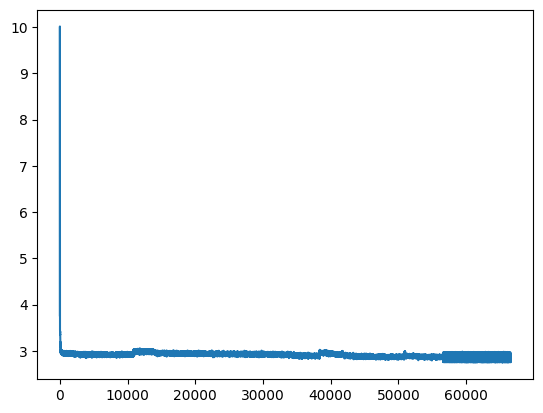

In [30]:
cst = ClassicalShadowTransformer(5,-6).load()
#print(cst.transformer.repara.logvar)
plt.plot(cst.loss_history)

### Fine Tuning

If necessary, a model can be loaded for fine tuning with smaller training rate to ensure convergence.

In [ ]:
cst = ClassicalShadowTransformer(5, -6).load()

In [ ]:
cst.optimize(1000, max_steps=10000, nsr=32, window=1000, n_sample=1000, lr=0.00001)

./model/CST_d64_h16_l1/GHZ_N5_b-6
531:  2.87878 -2.87629  0.15949 -0.35431


KeyboardInterrupt: 

## Evaluation

### Loss Function History

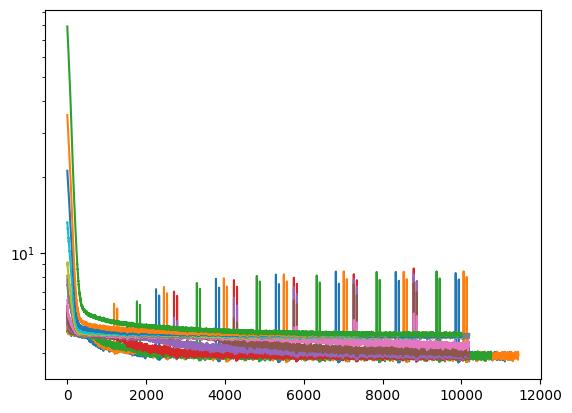

In [35]:
for logbeta in range(-6,7):
    cst = ClassicalShadowTransformer(7,logbeta).load()
    plt.plot(cst.loss_history)
    plt.yscale('log')
    


### Fidelity and Entropy Map

Compute fidelity and entropy (in unit of bit) of the reconstructed density matrix.

In [38]:

import gc
gc.collect()
data = []

In [39]:
import numpy as np
for n_qubit in range(1, 7):
    for logbeta in tqdm(range(-6, 7)):
        cst = ClassicalShadowTransformer(n_qubit, logbeta).load().eval()
        with torch.no_grad():
            rho = cst.rho().matrix_form(n_qubit)/2**cst.n_qubit # reconstruction
        # compute fidelity
        fid = (rho[0,0] + rho[-1,-1] + rho[0,-1] + rho[-1,0])/2
        fid = fid.real.item()
        vals = np.linalg.eigvalsh(rho)
        vals = vals[vals > 0.]
        ent = -np.log2(vals).dot(vals).item()
        clear_output(wait=True)
        print(cst.path + '/' + cst.file)
        print(f'F = {fid}, S = {ent}')
        data.append([n_qubit, logbeta, fid, ent])
        gc.collect()

data

100%|██████████| 13/13 [03:24<00:00, 15.70s/it]

./model/CST_d64_h16_l1/GHZ_N6_b6
F = 0.046308394437801326, S = 5.149879428136716


[[1, -6, 0.9999611079692841, -8.740147163627765e-05],
 [1, -5, 0.9999701976776123, -6.761229188749328e-05],
 [1, -4, 0.9999535083770752, -5.098903469466436e-05],
 [1, -3, 0.9999237954616547, -7.758078621443888e-05],
 [1, -2, 0.999833732843399, 0.000992598157835814],
 [1, -1, 0.9998943507671356, 0.00033788567989863024],
 [1, 0, 0.999840646982193, 0.0006358839002583679],
 [1, 1, 0.9998319149017334, 0.0014512450564470657],
 [1, 2, 0.9997420608997345, 0.0032612744964470065],
 [1, 3, 0.9976140856742859, 0.023566572931327585],
 [1, 4, 0.6669470071792603, 0.7431900446059414],
 [1, 5, 0.6662160754203796, 0.7454913670078737],
 [1, 6, 0.6652795523405075, 0.7486829458417945],
 [2, -6, 0.999695748090744, 0.06401194022043513],
 [2, -5, 0.9998426586389542, 0.03914306077585899],
 [2, -4, 0.9997840374708176, 0.0668632575975332],
 [2, -3, 0.9997417330741882, 0.04316181090222406],
 [2, -2, 0.9997195452451706, 0.04103686821707506],
 [2, -1, 0.9998792856931686, 0.05270804122181405],
 [2, 0, 0.999645873904

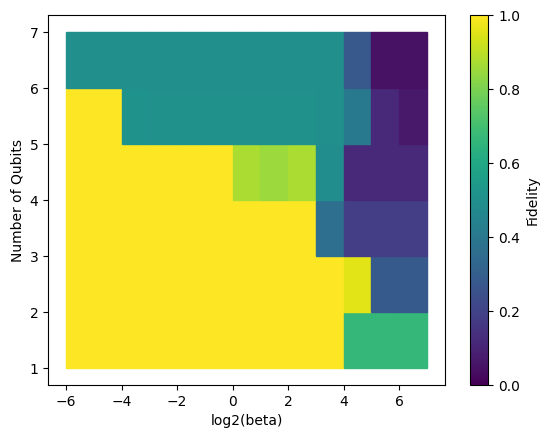

[[1, -6, 0.9999611079692841, -8.740147163627765e-05],
 [1, -5, 0.9999701976776123, -6.761229188749328e-05],
 [1, -4, 0.9999535083770752, -5.098903469466436e-05],
 [1, -3, 0.9999237954616547, -7.758078621443888e-05],
 [1, -2, 0.999833732843399, 0.000992598157835814],
 [1, -1, 0.9998943507671356, 0.00033788567989863024],
 [1, 0, 0.999840646982193, 0.0006358839002583679],
 [1, 1, 0.9998319149017334, 0.0014512450564470657],
 [1, 2, 0.9997420608997345, 0.0032612744964470065],
 [1, 3, 0.9976140856742859, 0.023566572931327585],
 [1, 4, 0.6669470071792603, 0.7431900446059414],
 [1, 5, 0.6662160754203796, 0.7454913670078737],
 [1, 6, 0.6652795523405075, 0.7486829458417945],
 [2, -6, 0.999695748090744, 0.06401194022043513],
 [2, -5, 0.9998426586389542, 0.03914306077585899],
 [2, -4, 0.9997840374708176, 0.0668632575975332],
 [2, -3, 0.9997417330741882, 0.04316181090222406],
 [2, -2, 0.9997195452451706, 0.04103686821707506],
 [2, -1, 0.9998792856931686, 0.05270804122181405],
 [2, 0, 0.999645873904

In [41]:
import numpy as np

x, y, z, _ = np.array(data).T
square_size = 1.0

fig, ax = plt.subplots()

for x, y, z in zip(y, x, z):
    square = plt.Rectangle((x, y), square_size, square_size, color=plt.cm.viridis(z))
    ax.add_patch(square)


sc = plt.scatter([], [], c=[], cmap='viridis', s=100)
plt.colorbar(sc, label='Fidelity')
ax.set_ylabel('Number of Qubits')
ax.set_xlabel('log2(beta)')
plt.show()

data

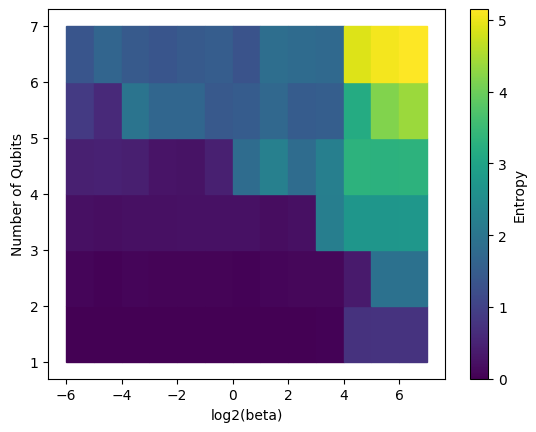

In [44]:
import numpy as np

x, y, _, z = np.array(data).T
square_size = 1.0

max_z = np.max(z)
fig, ax = plt.subplots()

for x, y, z in zip(y, x, z):
    square = plt.Rectangle((x, y), square_size, square_size, color=plt.cm.viridis(z/max_z))
    ax.add_patch(square)



sc = plt.scatter([], [], c=[], cmap='viridis', s=100, vmin=0, vmax=max_z)
plt.colorbar(sc, label='Entropy')
ax.set_ylabel('Number of Qubits')
ax.set_xlabel('log2(beta)')
plt.show()

In [ ]:

fig, ax = plt.subplots()

for x, y, z in zip(x, y, z):
    square = plt.Rectangle((x - square_size / 2, y - square_size / 2), square_size, square_size, color=plt.cm.viridis(z))
    ax.add_patch(square)


sc = plt.scatter([], [], c=[], cmap='viridis', s=100)
plt.colorbar(sc, label='Fidelity')
ax.set_xlabel('Number of Qubits')
ax.set_ylabel('log2(beta)')
plt.show()

In [ ]:
with open('./data/map.dat', 'wb') as f:
    pickle.dump(data, f)

Fidelity for 6 qubits (and beyond) can only be estimated by classical shadow tomography. First, prepare the GHZ state density matrix and convert it to Operator class.

In [ ]:
rho = qst.ghz_state(6).density_matrix
tok = rho.tokenize()
paulis = tok[:,:-1]
coeffs = (9.-2.*tok[:,-1]) * rho.cs
rho = Operator(torch.tensor(paulis), torch.tensor(coeffs))

Then evaluate the expectation value of the density matrix on the classical shadow ensemble.

In [ ]:
#data = []
for logbeta in range(2, 7):
    cst = ClassicalShadowTransformer(6, logbeta, embed_dim=128, n_layers=2).load().eval();
    clear_output(wait=True)
    print(cst.path + '/' + cst.file)
    fids = []
    for _ in range(5):
        shd = cst.sample(100000)
        fid = rho.expectation(shd, batch_size=1000).real.item()
        print(f'F = {fid:8.5f}')
        fids.append(fid)
    data.append([6, logbeta, fids])

./model/CST_d128_h16_l2/GHZ_N6_b6
F =  0.07216
F =  0.06822
F =  0.05655
F =  0.07230
F =  0.08284


In [ ]:
with open('./data/fid6_d128_l2.dat', 'wb') as f:
    pickle.dump(data, f)

### Atlas Boreas Cygnus

Take three representative models.

In [ ]:
mdls = {
    'atlas': ClassicalShadowTransformer(5, -5).load().eval(),
    'boreas': ClassicalShadowTransformer(5, -1).load().eval(),
    'cygnus': ClassicalShadowTransformer(5, 6).load().eval()}

Chat with the model. Dictionary:

| Number | Symbol |
|--------|--------|
| `1`    | `+`    |
| `2`    | `-`    |
| `3`    | `I`    |
| `4`    | `X`    |
| `5`    | `Y`    |
| `6`    | `Z`    |

* Z-test: `x: ZZZZZ, y:abcd?`, where $a,b,c,d\in\{+,-\}$ 
* X-test: `x: XXXXX, y:abcd?`, where $a,b,c,d\in\{+,-\}$ 
* XZ-test: `x: XXXXZ, y:abcd?`, where $a,b,c,d\in\{+,-\}$ 

Collect data:

In [ ]:
data = {}
y0 = torch.cartesian_prod(*[torch.tensor([1,2])]*4)
y = torch.cat([y0,torch.zeros(y.shape[0], dtype=torch.long)[:,None]],1)
x = torch.zeros_like(y) + 6
data['obs'] = y0.tolist()
with torch.no_grad():
    for name, mdl in mdls.items():
        logit = mdl.transformer(x, y)[:,-1]
        data[name] = logit.tolist()
with open('./data/z_test.dat', 'wb') as f:
    pickle.dump(data, f)

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 16 but got size 3 for tensor number 1 in the list.

In [ ]:
data = {}
y0 = torch.cartesian_prod(*[torch.tensor([1,2])]*4)
y = torch.cat([y0,torch.zeros(y.shape[0], dtype=torch.long)[:,None]],1)
x = torch.zeros_like(y) + 4
data['obs'] = y0.tolist()
with torch.no_grad():
    for name, mdl in mdls.items():
        logit = mdl.transformer(x, y)[:,-1]
        data[name] = logit.tolist()
with open('./data/x_test.dat', 'wb') as f:
    pickle.dump(data, f)

In [ ]:
data = {}
y0 = torch.cartesian_prod(*[torch.tensor([1,2])]*4)
y = torch.cat([y0,torch.zeros(y.shape[0], dtype=torch.long)[:,None]],1)
x = torch.zeros_like(y) + 4
x[:,-1] = 6
data['obs'] = y0.tolist()
with torch.no_grad():
    for name, mdl in mdls.items():
        logit = mdl.transformer(x, y)[:,-1]
        data[name] = logit.tolist()
with open('./data/xz_test.dat', 'wb') as f:
    pickle.dump(data, f)

### Density Matrix Reconstruction

Reconstruct density matrices for representative models.

In [ ]:
data = {}
for name, mdl in mdls.items():
    with torch.no_grad():
        rho = mdl.rho().matrix_form()/2**mdl.n_qubit # reconstruction
    data[name] = rho.tolist()
with open('./data/rhos.dat', 'wb') as f:
    pickle.dump(data, f)

### Latent Space Structure

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(2)
x = torch.cartesian_prod(*[torch.tensor([4,5,6])]*5)
data = {'x': (x-3).tolist()}
for name, mdl in mdls.items():
    with torch.no_grad():
        src = mdl.transformer.embed(x)
        mem = mdl.transformer.encode(src)
    mem = mem.view(mem.shape[0],-1)
    z = tsne.fit_transform(mem)
    data[name] = z.tolist()
with open('./data/z_embed.dat', 'wb') as f:
    pickle.dump(data, f)

In [ ]:
import numpy as np

# Create two 4x4 NumPy arrays
array1 = np.array([[1, 2, 3, 4],
                   [5, 6, 7, 8],
                   [9, 10, 11, 12],
                   [13, 14, 15, 16]])

array2 = np.array([[10, 20, 30, 40],
                   [50, 60, 70, 80],
                   [90, 100, 110, 120],
                   [130, 140, 150, 160]])
c=[1]
# Add the arrays element-wise
result = array1 + c * array2

# Print the result
print(result)


[[ 11  22  33  44]
 [ 55  66  77  88]
 [ 99 110 121 132]
 [143 154 165 176]]


In [ ]:
import gc
gc.collect()

4258